### Random Forest Model
<br>
First version completed on July 5 by Li Xiuxian.
<br><br>

In [1]:
# modify those modules, jupyter notebook will automatically update the code
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.tabular import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import forest
from IPython.display import display
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

from sklearn import metrics

In [3]:
PATH = "data/bulldozers/"

In [4]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=['saledate'])

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [6]:
# display_all(df_raw.tail().transpose())

In [7]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

Predicting continuous variables -> method: regression; tool: regressor

Predicting discrete / categorical variables -> method: classification; tool: classifier

Regression is a Machine Learning model trying to predict continuous outcome.

Streps using Machine Leaning models in sklean:
    1. Create an instance for the Machine Learning model
    2. Call fit() of the instance and pass in the independent variable and dependent variables
    

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals. You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these fields, you cannot capture any trend/cyclical behavior as a function of time at any of these granularities.

In [8]:
fld = df_raw.saledate

In [9]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and does not provide hte numeric coding required for a random forest. Therefore, we call *train_cats* to convert strings to pandas categories.

In [10]:
# Copied from the old version of fastai (fastai.structured)
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

In [11]:
# Turn string objects in the dataframe to categorical values 
# In this particular case, only UsageBand contains nonnumerical values 
# NaN / null values will be automatically labeled by pandas by -1
train_cats(df_raw)
df_raw.UsageBand.cat.set_categories(['High', 'Medium','Low'], ordered=True, inplace=True)

# display_all(df_raw.isnull().sum().sort_index() / len(df_raw))

Data preprocessing almost done

--- Format Conversion ---
1. Strings are converted to numbers.
    Decision trees will see 'High', 'Medium' and 'Low' as 0. 1 and 2. 
    String -> Categorical Values (can be represented using numeric numbers)
2. Dates are converted to a bunch of numeric columns.
3. verything else is already numbers.

--- Deal with null values ---

In [12]:
# Save to disk in exactly the same format that is actually in RAM
# Far faster in saving and reading data (good for cross-computer communication)
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/raw')

# Read the data back
df_raw = pd.read_feather('tmp/raw')

In [13]:
# Copied from the old version of fastai (fastai.structured) 
# https://github.com/fastai/fastai/blob/master/old/fastai/structured.py
def numericalize(df, col, name, max_n_cat):
    ''' For values not numeric, convert it to corresponding categorical values + 1.abc
    e.g. NaN values are not -1 but 0.'''
    
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = pd.Categorical(col).codes+1
    
    
def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = pd.Categorical(df[y_fld]).codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples:
    forest.check_random_state(rs).randint(0, n_samples, n))

Deal with missing values
1. Use the categorical values + 1
2. Replace the missing values using the median
3. Add an additional column telling which values are replaced
4. Remove the independent variable (y)

In [14]:
# 'SalePrice' is denoted as the dependent variable (Y -> prediction results & labels)
#  proc_df() will extract the dependent variable column and fix missing
 
df, y, nas =  proc_df(df_raw, 'SalePrice')

In [15]:
# To avoid overfitting, we usually need a validation set

def split_vals(a, n): return a[:n].copy(), a[n:].copy()


n_valid = 12000 
n_trn =  len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [16]:
''' Rather than limit the total amount of data that our model can access,
        limit it to a different random subset per tree.
'''
set_rf_samples(20000)

In [17]:
# Calcualte the root-mean-square deviation (how close is the prediction result to the acutal result)
def rmse(x, y): 
    return math.sqrt(((x - y)**2).mean())


def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [18]:
# Random forests are trivially parallelizable
#  It will split the data across different CPUs (linearly scale right)
# n_jobs=-1 tells the random forest to separate the work for each CPU (separate processes)

m = RandomForestRegressor(n_jobs=-1)
%time
m.fit(X_train, y_train)
print_score(m)

# The score of training set is 0.98, while the result of validaiton set is only 0.88
# Overfitting occurs 

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.24130437340199884, 0.2754773706969302, 0.8783071079334307, 0.86447487005152]


#####  The Random Forest Algorithm
Have a closer look at the Random Forest algorithm.

In sklearn, construct a self-design random forest using parameters.

In [19]:
""" Random forest consists of several decision trees.
In sklearn, decision trees are estimators. 
Denote the number of decision trees using parameter n_estimator.

max_depth parameter is used to specify the scale/depth of decision trees.
max_depth = 3 is a small decision tree with three layers.

Parameter bootstrap is used to control the randomization of the random forest.
"""

m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5371269683343529, 0.5674541015387207, 0.3970396664995464, 0.42494490873720825]


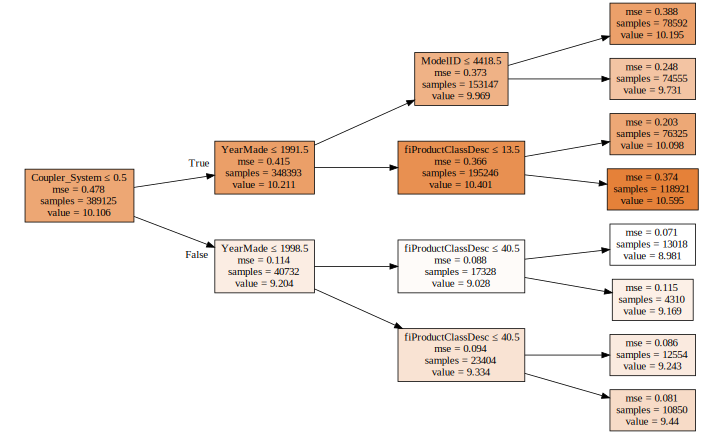

In [20]:
# Copied from the old version of fastai (fastai.structured) 
# https://github.com/fastai/fastai/blob/master/old/fastai/structured.py

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))


draw_tree(m.estimators_[0], df, precision=3)

Beginning at knowing nothing about how to split the tree can produce the best result, we try on each variable for each possible split. For each possible split, we note down the weighted average mse (the sum of two mse\*samples). Finally, we check which possible split has the smallest weighted average mse (prediction results are most close to the acutal value), and **split on it.** 
<br><br>
In the above tree, splitting starts at checking whether *Coupler_System* of *df* is smaller or equal to 0.5. If we simply predict the result using the mean value of *y*, we get a mean-square-error of 0.478. We want to minimize mse in the following sub-devisions.
<br><br>
Split stops at either we hit some limits (e.g. max_depth = 3), or one leaf node only have one thing in it, namely the size of 1. Once a point fells in a pure leaf node, we can instantly retrieve its correct prediction result.

In [21]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[8.58675118495947e-07, 0.35526665442852173, 0.999999999998459, 0.7745984664836758]


Remove the limitaion max_depth = 3, split stops when it gets to pure result sets.

The performance will be greatly improve from 0.397 to 0.999. <br><br>

However the decision tree is still overfitting with the score in the validation set around 0.78.

To solve this problem, we create a forest instead of a single decision tree.
<br><br><br>
#### Bagging Technique (Create Forest)
To create a forest, we use a statistical technique called bagging. Bagging on models can make its performance more robust, and yield confident intervals.
<br><br>
We create several models, each of them is somewhat predictive. These models will not correlate with each other. Therefore, these models will have profound different insights in the data. The technique **Ensembling** takes the insight of each model to produce a comprehensive result.
<br><br>
In stead of feed in all data to one decision tree, we just feed in a small part of the data. That tree will fit perfectly on its data, while produce crappy results on the rest. But each tree is more than nothing, because it do actually have a real random subset.
<br><br>
##### Random Forest - predictive but poorly correlated trees 

In [22]:
# By defualt, sklearn constructs ten trees
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/opt/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.24183901179394154, 0.2794719162435732, 0.8777672605436322, 0.8605160236759455]


In [23]:
# Decision trees are stored in m.estimators_
# Each tree predict a result for elements in the validaiton set
preds = np.stack([t.predict(X_valid) for t in m.estimators_])

# Average prediction results of all trees, compare to the actual value
preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

(array([9.350102, 9.159047, 9.350102, 9.159047, 9.169518, 9.259131, 9.21034 , 9.047821, 9.903488, 8.987197]),
 9.25957938851342,
 9.104979856318357)

<br><br>
Use the standard deviation to get the confidence of the prediction.
<br><br>
In a particular leaf node with several samples in it, if the standard deviation is low, we will have the confidence to say that these samples have great similarity. 

In [25]:
def get_preds(t): 
    return t.predict(X_valid)


def parallel_trees(m, fn, n_jobs=8):
    return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))


''' In the above cell, we iterate through all trees in the estimators set linearly.
To reduce time used, we could run in parallel by calling parallel_trees().
'''
preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:, 0]), np.std(preds[:, 0])

(9.25957938851342, 0.24099572068573766)

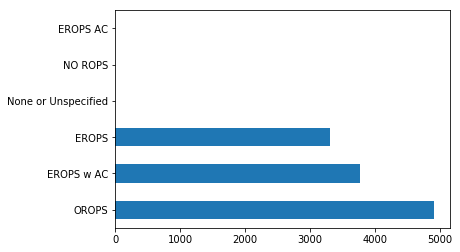

In [26]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

# Enclosure is an important predictor
x.Enclosure.value_counts().plot.barh();

In [27]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839218,0.294614
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.564894,0.295393
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.662862,0.255899


In [28]:
preds.shape

(10, 12000)

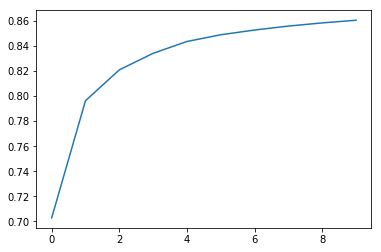

In [29]:
''' For tree number i in the forest (ten trees all together),
    we check the first i rows ([:i+1]) of the prediction results.
    
    We feed the prediction results and the acutal value y to R-Squared evaluation model,
    and find that the R-Squared value is increasing when more numbers are added to the formula.
    
    In this way, bagging generalizes better results, as shown in the graph below.
    
    At some points, the increasing of R-Squared value will stop. No need to add more estimators.
'''

plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

#### Out-Of-Bag Problem

When the data set is not very large, we need to use validation set, but we also do not want to waste data to train our model. 
<br> <br> 
In this case, we use different validation set for different trees. Since for each tree, only a random subset is picked for training, the rest will be used as the validation set. 
<br> <br> 
If we do not have out-of-bag problem, normally as what we do above, we will separate the validation set beforehand, and every tree will use the same validation set. 
<br> <br> 
To enable out-of-bag, set parameter oob_score=True.

In [30]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, min_samples_leaf=3, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2316886711497545, 0.2621781005520452, 0.8878125120976921, 0.877244545263313, 0.8787616917836224]


In [31]:
# Max_feature is the number of features to consider each time to determine which feature to split in a node
# Max_feature is used to avoid overfitting
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, max_features=0.5,min_samples_leaf=3, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.23324320997787457, 0.26323941903032594, 0.8863019947144304, 0.876248685353247, 0.877770695759565]


<br><br> 
#### Feature Importance
<br>
We should not only know that the model can make accurate predictions, we also want to know how it is making predictions. The most important way to see this is with *Feature Importance*.
<br><br>
*Feature importance* tells us that in this random forest, which columns matters. Which features contribute greatly in prediction.

In [34]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)


fi = rf_feat_importance(m, df)
fi[:10]

,cols,imp
5,YearMade,0.173446
13,ProductSize,0.100971
14,fiProductClassDesc,0.080475
37,Coupler_System,0.077182
39,Hydraulics_Flow,0.055055
2,ModelID,0.053651
63,saleElapsed,0.047798
38,Grouser_Tracks,0.045901
19,Enclosure,0.042632
10,fiSecondaryDesc,0.040736


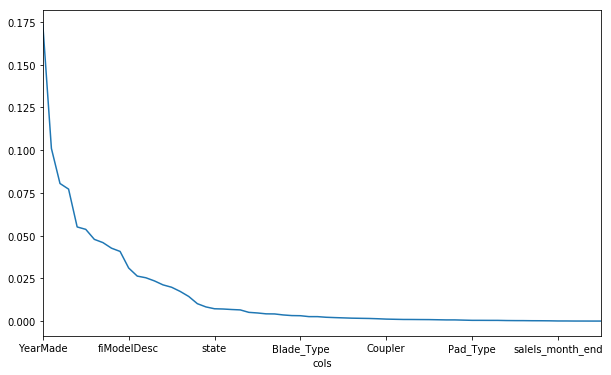

In [36]:
fi.plot('cols', 'imp', figsize=(10, 6), legend=False)

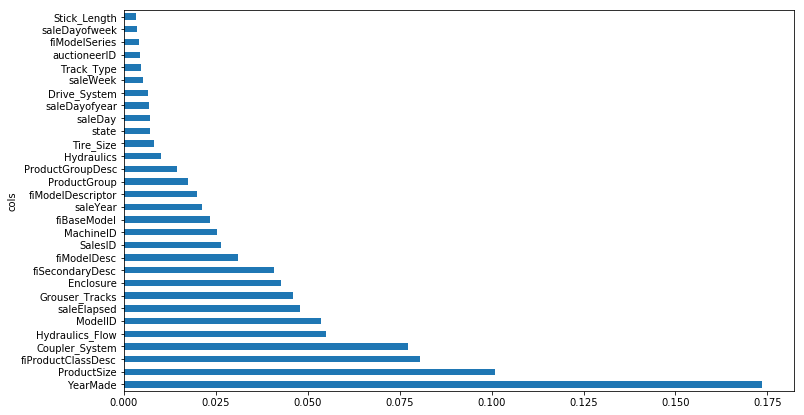

In [37]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

plot_fi(fi[:30])

In [39]:
# Create a dataframe with the most important severl columns (imp > 0.005) and train the model
# Remove some extractions, redundant columns usually have some negative results

to_keep = fi[fi.imp>0.005].cols
len(to_keep)

25

In [40]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, 
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.23338820554282985, 0.26164551111765033, 0.8861605901206653, 0.8777427703497551, 0.877899909221128]


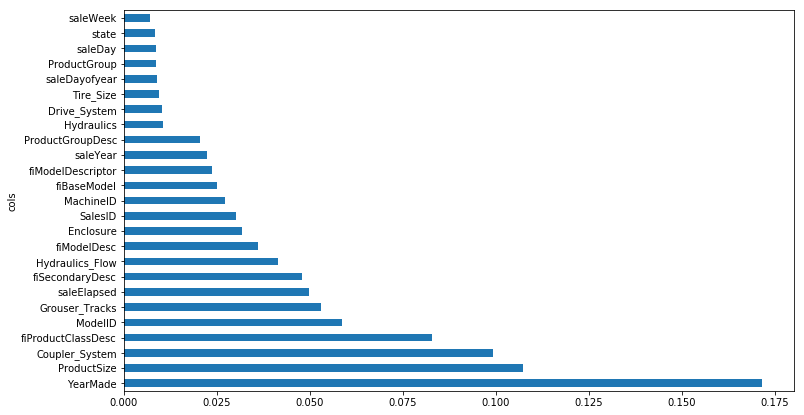

In [43]:
# Remove many inter-related columns makes the feature importance more clearer

fi = rf_feat_importance(m, df_keep)
plot_fi(fi[:30])